In [5]:
import numpy as np
import scipy as sp
from scipy.fft import fft
from scipy.signal import butter, lfilter
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, roc_curve, auc
import matplotlib.pyplot as plt
import pickle
import random
import os
from google.colab import drive

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
seed = 57

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [8]:
drive.mount('/content/drive')
x = pickle.load(open('/content/drive/MyDrive/CI_Dataset/x.pkl', 'rb'))
y = pickle.load(open('/content/drive/MyDrive/CI_Dataset/y.pkl', 'rb'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
normal_samples = x[0:400]
seizure_samples = x[400:500]

In [10]:
sampling_freq = 173.6

b, a = butter(3, [0.5,40], btype='bandpass',fs=sampling_freq)

normal_samples_filtered = np.array([lfilter(b, a, normal_samples[ind, :]) for ind in range(normal_samples.shape[0])])
seizure_samples_filtered = np.array([lfilter(b, a, seizure_samples[ind, :]) for ind in range(seizure_samples.shape[0])])

In [11]:
def get_features_added_data_points(data_points):
  features_added_data_points = []
  index = 0

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.min(data_point)) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.max(data_point)) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.mean(data_point)) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.sqrt(np.min(data_point ** 2))) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.var(data_point)) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.std(data_point)) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.mean(data_point ** 2)) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.max(np.abs(data_point))) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.ptp(data_point)) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.max(np.abs(data_point)) / np.sqrt(np.mean(data_point ** 2))) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(stats.skew(data_point)) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(stats.kurtosis(data_point)) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.sqrt(np.mean(data_point ** 2)) / np.mean(data_point)) for data_point in data_points]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.max(np.abs(data_point)) / np.mean(data_point)) for data_point in data_points]
  index += 1

  fourier_transformed_data_points = []
  [fourier_transformed_data_points.append(fft(data_point)) for data_point in data_points]

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.max(np.abs(fourier_transformed_data_points[data_point_index]**2) / len(data_points))) for data_point_index in range(len(data_points))]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.sum(np.abs(fourier_transformed_data_points[data_point_index]**2) / len(data_points))) for data_point_index in range(len(data_points))]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.mean(np.abs(fourier_transformed_data_points[data_point_index]**2) / len(data_points))) for data_point_index in range(len(data_points))]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.var(np.abs(fourier_transformed_data_points[data_point_index]**2) / len(data_points))) for data_point_index in range(len(data_points))]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(np.max(np.abs(np.abs(fourier_transformed_data_points[data_point_index]**2) / len(data_points)))) for data_point_index in range(len(data_points))]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(stats.skew(np.abs(fourier_transformed_data_points[data_point_index]**2) / len(data_points))) for data_point_index in range(len(data_points))]
  index += 1

  features_added_data_points.append([])
  [features_added_data_points[index].append(stats.kurtosis(np.abs(fourier_transformed_data_points[data_point_index]**2) / len(data_points))) for data_point_index in range(len(data_points))]
  index += 1

  features_added_data_points = np.array(features_added_data_points).T

  return features_added_data_points

In [12]:
def test_parameters(data_points_train, data_points_test, labels_train, labels_test, algorithm):
  labels_prediction = algorithm.predict(data_points_test)

  accuracy = accuracy_score(labels_test, labels_prediction)
  precision = precision_score(labels_test, labels_prediction, average = 'binary')
  recall = recall_score(labels_test, labels_prediction, average='binary')
  
  print("Accuracy = ", round(accuracy, 3), "\t& ", end = " ")
  print("Precision = ", round(precision, 3), "\t& ", end = " ")
  print("Recall = ", round(recall, 3))

  return accuracy, precision, recall

In [13]:
def k_folf_cross_validation (data_points, algorithm, best_result_plot_parameters_flag = False):
  number_of_folds = 5
  k_fold = KFold(n_splits = number_of_folds, shuffle = True, random_state = seed)

  mean_accuracy = 0
  mean_precision = 0
  mean_recall = 0
  fold = 1

  if best_result_plot_parameters_flag:
    fig, roc_plot = plt.subplots(1, 5, figsize = (30, 5))

  for train, test in k_fold.split(data_points):
    data_points_train = data_points[train]
    data_points_test = data_points[test]
    labels_train = labels[train]
    labels_test = labels[test]
    
    algorithm.fit(data_points_train, labels_train.flatten())

    print("Fold ", fold, " => ", end = " ")
    accuracy, precision, recall = test_parameters(data_points_train, data_points_test, labels_train, labels_test, algorithm)

    mean_accuracy += accuracy
    mean_precision += precision
    mean_recall += recall

    if best_result_plot_parameters_flag:

      best_result_labels_prediction = algorithm.predict_proba(data_points_test)
      best_result_labels_prediction = best_result_labels_prediction[:, 1]
      best_result_false_positive_rate, best_true_positive_rate, threshold = roc_curve(labels_test, best_result_labels_prediction)
      best_result_auc = auc(best_result_false_positive_rate, best_true_positive_rate)

      label_predict_best = algorithm.predict(data_points_test)
      confusion_best = confusion_matrix(labels_test, label_predict_best)
      print("Confusion Matrix: \n", confusion_best)

      roc_plot[fold - 1].plot(best_result_false_positive_rate, best_true_positive_rate, marker='.', label="best" % best_result_auc)
      roc_plot[fold - 1].set_title("Fold = " + str(fold))

    fold += 1

  mean_accuracy /= number_of_folds
  mean_precision /= number_of_folds
  mean_recall /= number_of_folds

  if best_result_plot_parameters_flag:
    print("\n")

  return mean_accuracy, mean_precision, mean_recall

In [14]:
def algorithm_implementation (data_points, algorithm_type, best_result_plot_parameters_flag = False, best_result_index = 0):
  algorithm = None

  if algorithm_type == "SVM":

    kernels = ["linear", "poly", "rbf", "sigmoid"]

    if best_result_plot_parameters_flag:
      print(kernels[best_result_index], " Kernel")
      algorithm = SVC(kernel = kernels[best_result_index], max_iter = 10000, probability = True)
      k_folf_cross_validation(data_points, algorithm, best_result_plot_parameters_flag)
    else:
      svm_test_parameters = np.zeros((len(kernels), 3))

      for kernel_index in range(len(kernels)):
        print(kernels[kernel_index], " Kernel")
        algorithm = SVC(kernel = kernels[kernel_index], max_iter = 10000)
        svm_test_parameters[kernel_index] = k_folf_cross_validation(data_points, algorithm)

      return svm_test_parameters

  elif algorithm_type == "Random Forest":

    estimator_values = np.arange(10, 200, 20)

    if best_result_plot_parameters_flag:
      print("Number of Trees = ", estimator_values[best_result_index])
      algorithm = RandomForestClassifier(n_estimators = estimator_values[best_result_index])
      k_folf_cross_validation(data_points, algorithm, best_result_plot_parameters_flag)
    else:
      random_forest_test_parameters = np.zeros((len(estimator_values), 3))

      for estimator_value_index in range(len(estimator_values)):
        print("Number of Trees = ", estimator_values[estimator_value_index])
        algorithm = RandomForestClassifier(n_estimators = estimator_values[estimator_value_index])
        random_forest_test_parameters[estimator_value_index] = k_folf_cross_validation(data_points, algorithm)
    
      return random_forest_test_parameters

  elif algorithm_type == "KNN":

    neighbor_values = np.arange(1, 50, 2)

    if best_result_plot_parameters_flag:
      print("Number of Neighbors = ", neighbor_values[best_result_index])
      algorithm = KNeighborsClassifier(n_neighbors = neighbor_values[best_result_index])
      k_folf_cross_validation(data_points, algorithm, best_result_plot_parameters_flag)
    else:
      knn_test_parameters = np.zeros((len(neighbor_values), 3))

      for neighbor_value_index in range(len(neighbor_values)):
        print("Number of Neighbors = ", neighbor_values[neighbor_value_index])
        algorithm = KNeighborsClassifier(n_neighbors = neighbor_values[neighbor_value_index])
        knn_test_parameters[neighbor_value_index] = k_folf_cross_validation(data_points, algorithm)
    
      return knn_test_parameters

  else:
    return

In [15]:
def get_best (result):
  max_mse = 0
  max_mse_index = 0
  for index in range (len(result)):
    mse = mean_squared_error(result[index], [1, 1, 1])
    if max_mse < mse:
      max_mse = mse
      max_mse_index = index
  return max_mse_index

Processing Not Normalized Data Points

In [16]:
normal_samples_not_normalized = normal_samples_filtered
seizure_samples_not_normalized = seizure_samples_filtered

data_points_not_normalized = np.concatenate((normal_samples_not_normalized, seizure_samples_not_normalized))
data_points_not_normalized = get_features_added_data_points(data_points_not_normalized)
labels = np.concatenate((np.zeros((400, 1)), np.ones((100, 1))))

In [17]:
print("Not Normalized Data Points :: SVM")
svm_not_normalized_test_parameters = algorithm_implementation(data_points_not_normalized, "SVM")

Not Normalized Data Points :: SVM
linear  Kernel
Fold  1  =>  Accuracy =  0.83 	&  Precision =  1.0 	&  Recall =  0.346
Fold  2  =>  Accuracy =  0.88 	&  Precision =  1.0 	&  Recall =  0.333
Fold  3  =>  Accuracy =  0.91 	&  Precision =  1.0 	&  Recall =  0.609
Fold  4  =>  Accuracy =  0.1 	&  Precision =  0.104 	&  Recall =  0.714
Fold  5  =>  Accuracy =  0.91 	&  Precision =  0.857 	&  Recall =  0.632
poly  Kernel
Fold  1  =>  Accuracy =  0.79 	&  Precision =  1.0 	&  Recall =  0.192
Fold  2  =>  Accuracy =  0.85 	&  Precision =  1.0 	&  Recall =  0.167
Fold  3  =>  Accuracy =  0.86 	&  Precision =  1.0 	&  Recall =  0.391
Fold  4  =>  Accuracy =  0.87 	&  Precision =  1.0 	&  Recall =  0.071
Fold  5  =>  Accuracy =  0.83 	&  Precision =  0.75 	&  Recall =  0.158
rbf  Kernel
Fold  1  =>  Accuracy =  0.9 	&  Precision =  0.944 	&  Recall =  0.654
Fold  2  =>  Accuracy =  0.92 	&  Precision =  1.0 	&  Recall =  0.556
Fold  3  =>  Accuracy =  0.95 	&  Precision =  1.0 	&  Recall =  0.78

In [18]:
print("Not Normalized Data Points :: Random Forest")
random_forest_not_normalized_test_parameters = algorithm_implementation(data_points_not_normalized, "Random Forest")

Not Normalized Data Points :: Random Forest
Number of Trees =  10
Fold  1  =>  Accuracy =  0.95 	&  Precision =  0.889 	&  Recall =  0.923
Fold  2  =>  Accuracy =  0.97 	&  Precision =  0.941 	&  Recall =  0.889
Fold  3  =>  Accuracy =  0.99 	&  Precision =  0.958 	&  Recall =  1.0
Fold  4  =>  Accuracy =  0.99 	&  Precision =  0.933 	&  Recall =  1.0
Fold  5  =>  Accuracy =  0.95 	&  Precision =  0.818 	&  Recall =  0.947
Number of Trees =  30
Fold  1  =>  Accuracy =  0.95 	&  Precision =  0.889 	&  Recall =  0.923
Fold  2  =>  Accuracy =  0.96 	&  Precision =  0.938 	&  Recall =  0.833
Fold  3  =>  Accuracy =  0.98 	&  Precision =  0.92 	&  Recall =  1.0
Fold  4  =>  Accuracy =  0.98 	&  Precision =  1.0 	&  Recall =  0.857
Fold  5  =>  Accuracy =  0.95 	&  Precision =  0.818 	&  Recall =  0.947
Number of Trees =  50
Fold  1  =>  Accuracy =  0.95 	&  Precision =  0.889 	&  Recall =  0.923
Fold  2  =>  Accuracy =  0.97 	&  Precision =  0.941 	&  Recall =  0.889
Fold  3  =>  Accuracy =

In [19]:
print("Not Normalized Data Points :: KNN")
knn_not_normalized_test_parameters = algorithm_implementation(data_points_not_normalized, "KNN")

Not Normalized Data Points :: KNN
Number of Neighbors =  1
Fold  1  =>  Accuracy =  0.92 	&  Precision =  0.909 	&  Recall =  0.769
Fold  2  =>  Accuracy =  0.97 	&  Precision =  0.895 	&  Recall =  0.944
Fold  3  =>  Accuracy =  0.93 	&  Precision =  0.808 	&  Recall =  0.913
Fold  4  =>  Accuracy =  0.96 	&  Precision =  0.917 	&  Recall =  0.786
Fold  5  =>  Accuracy =  0.94 	&  Precision =  0.81 	&  Recall =  0.895
Number of Neighbors =  3
Fold  1  =>  Accuracy =  0.9 	&  Precision =  0.833 	&  Recall =  0.769
Fold  2  =>  Accuracy =  0.95 	&  Precision =  0.882 	&  Recall =  0.833
Fold  3  =>  Accuracy =  0.96 	&  Precision =  0.852 	&  Recall =  1.0
Fold  4  =>  Accuracy =  0.96 	&  Precision =  1.0 	&  Recall =  0.714
Fold  5  =>  Accuracy =  0.92 	&  Precision =  0.762 	&  Recall =  0.842
Number of Neighbors =  5
Fold  1  =>  Accuracy =  0.89 	&  Precision =  0.8 	&  Recall =  0.769
Fold  2  =>  Accuracy =  0.96 	&  Precision =  0.938 	&  Recall =  0.833
Fold  3  =>  Accuracy =

In [20]:
kernels = ["linear", "poly", "rbf", "sigmoid"]
estimator_values = np.arange(10, 200, 20)
neighbor_values = np.arange(1, 50, 2)

In [21]:
best_svm_not_normalized_index = get_best(svm_not_normalized_test_parameters)
best_svm_not_normalized = svm_not_normalized_test_parameters[best_svm_not_normalized_index]
print("Best Not Normalized Data Points :: SVM :: ", kernels[best_svm_not_normalized_index], " Kernel")
print("Accuracy = ", round(best_svm_not_normalized[0], 3), " & ", end = " ")
print("Precision = ", round(best_svm_not_normalized[1], 3), " & ", end = " ")
print("Recall = ", round(best_svm_not_normalized[2], 3), "\n")

best_random_forest_not_normalized_index = get_best(random_forest_not_normalized_test_parameters)
best_random_forest_not_normalized = random_forest_not_normalized_test_parameters[best_random_forest_not_normalized_index]
print("Best Not Normalized Data Points :: Random Forest :: Estimator = ", estimator_values[best_random_forest_not_normalized_index])
print("Accuracy = ", round(best_random_forest_not_normalized[0], 3), " & ", end = " ")
print("Precision = ", round(best_random_forest_not_normalized[1], 3), " & ", end = " ")
print("Recall = ", round(best_random_forest_not_normalized[2], 3), "\n")

best_knn_not_normalized_index = get_best(knn_not_normalized_test_parameters)
best_knn_not_normalized = knn_not_normalized_test_parameters[best_knn_not_normalized_index]
print("Best Not Normalized Data Points :: KNN :: Neighbors = ", neighbor_values[best_knn_not_normalized_index])
print("Accuracy = ", round(best_knn_not_normalized[0], 3), " & ", end = " ")
print("Precision = ", round(best_knn_not_normalized[1], 3), " & ", end = " ")
print("Recall = ", round(best_knn_not_normalized[2], 3), "\n")

not_normalized_test_parameters_titles = ["SVM", "Random Forest", "KNN"]
not_normalized_test_parameters = [best_svm_not_normalized, best_random_forest_not_normalized, best_knn_not_normalized]
best_not_normalized_index = get_best(not_normalized_test_parameters)
best_not_normalized = not_normalized_test_parameters[best_not_normalized_index]
print("Best Not Normalized Data Points :: ", not_normalized_test_parameters_titles[best_not_normalized_index], " Algorithm")
print("Accuracy = ", round(best_not_normalized[0], 3), " & ", end = " ")
print("Precision = ", round(best_not_normalized[1], 3), " & ", end = " ")
print("Recall = ", round(best_not_normalized[2], 3), "\n")

Best Not Normalized Data Points :: SVM ::  poly  Kernel
Accuracy =  0.84  &  Precision =  0.95  &  Recall =  0.196 

Best Not Normalized Data Points :: Random Forest :: Estimator =  30
Accuracy =  0.964  &  Precision =  0.913  &  Recall =  0.912 

Best Not Normalized Data Points :: KNN :: Neighbors =  21
Accuracy =  0.938  &  Precision =  0.921  &  Recall =  0.753 

Best Not Normalized Data Points ::  SVM  Algorithm
Accuracy =  0.84  &  Precision =  0.95  &  Recall =  0.196 



poly  Kernel
Fold  1  =>  Accuracy =  0.79 	&  Precision =  1.0 	&  Recall =  0.192
Confusion Matrix: 
 [[74  0]
 [21  5]]
Fold  2  =>  Accuracy =  0.85 	&  Precision =  1.0 	&  Recall =  0.167
Confusion Matrix: 
 [[82  0]
 [15  3]]
Fold  3  =>  Accuracy =  0.86 	&  Precision =  1.0 	&  Recall =  0.391
Confusion Matrix: 
 [[77  0]
 [14  9]]
Fold  4  =>  Accuracy =  0.87 	&  Precision =  1.0 	&  Recall =  0.071
Confusion Matrix: 
 [[86  0]
 [13  1]]
Fold  5  =>  Accuracy =  0.83 	&  Precision =  0.75 	&  Recall =  0.158
Confusion Matrix: 
 [[80  1]
 [16  3]]


Number of Trees =  30
Fold  1  =>  Accuracy =  0.93 	&  Precision =  0.828 	&  Recall =  0.923
Confusion Matrix: 
 [[69  5]
 [ 2 24]]
Fold  2  =>  Accuracy =  0.99 	&  Precision =  0.947 	&  Recall =  1.0
Confusion Matrix: 
 [[81  1]
 [ 0 18]]
Fold  3  =>  Accuracy =  0.99 	&  Precision =  0.958 	&  Recall =  1.0
Confusion Matrix: 
 [[76  1]
 [ 0 23]]
Fold  4  =>  Accuracy =  0.98 	&  Precision =  0.929 	&  Recall =  0.929
Confusi

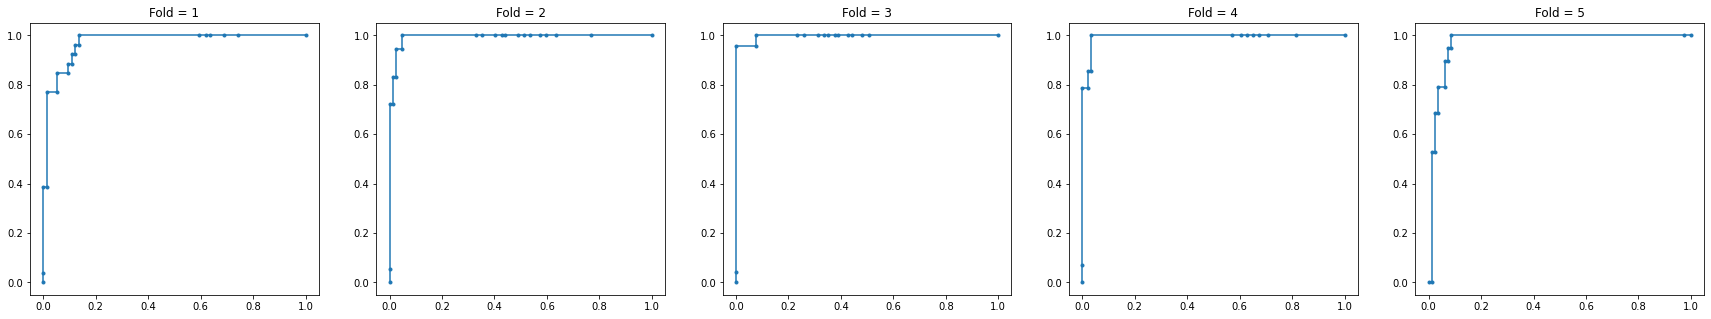

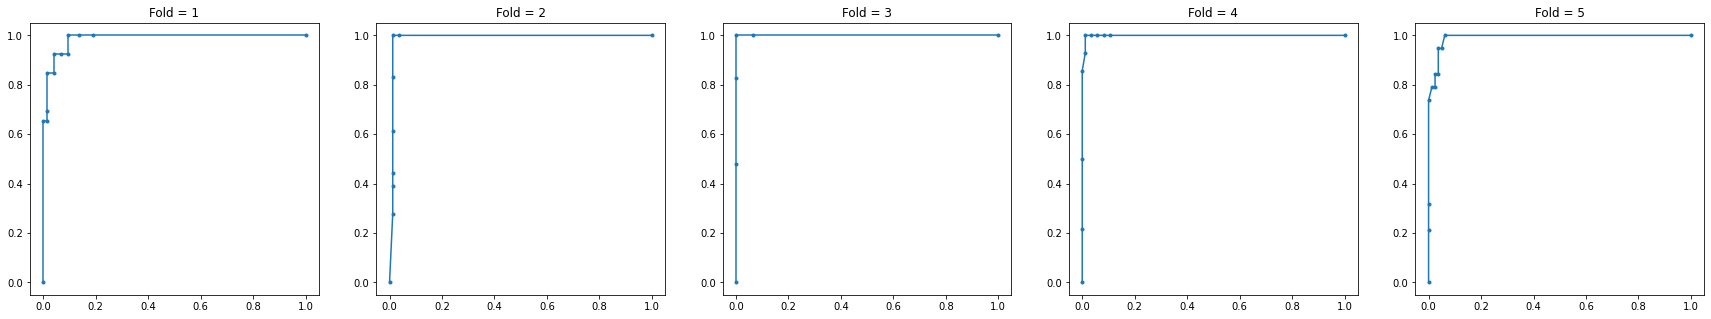

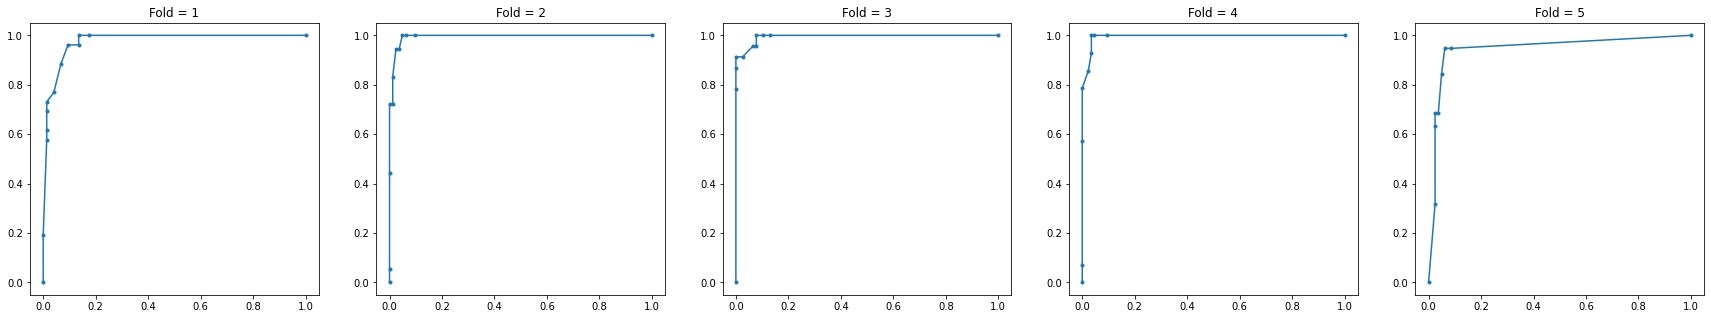

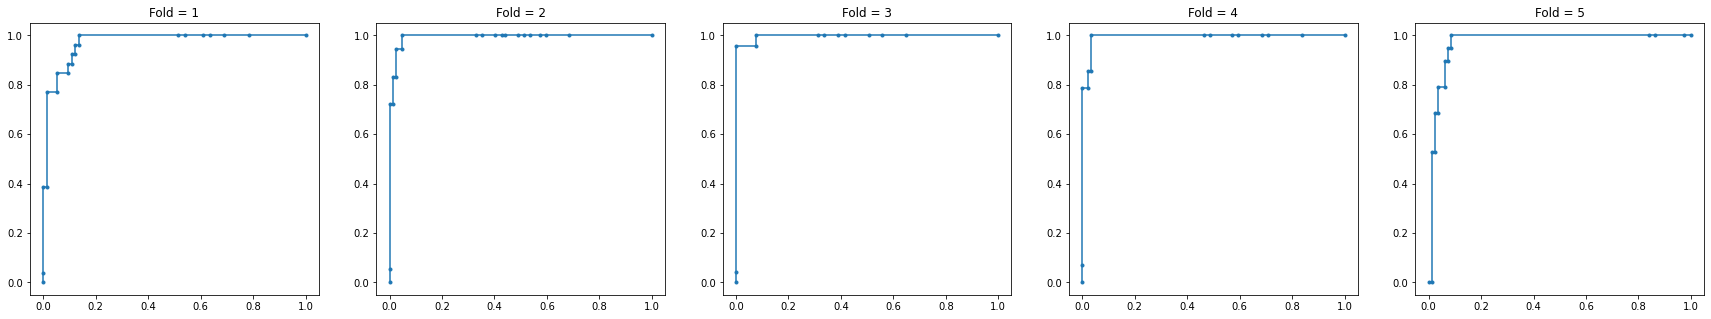

In [22]:
# SVM
algorithm_implementation(data_points_not_normalized, "SVM", True, best_svm_not_normalized_index)
# Random Forest
algorithm_implementation(data_points_not_normalized, "Random Forest", True, best_random_forest_not_normalized_index)
# KNN
algorithm_implementation(data_points_not_normalized, "KNN", True, best_knn_not_normalized_index)
# Best
if best_not_normalized_index == 0:
  algorithm_implementation(data_points_not_normalized, not_normalized_test_parameters_titles[best_not_normalized_index], True, best_svm_not_normalized_index)
elif best_not_normalized_index == 1:
  algorithm_implementation(data_points_not_normalized, not_normalized_test_parameters_titles[best_not_normalized_index], True, best_random_forest_not_normalized_index)
else:
  algorithm_implementation(data_points_not_normalized, not_normalized_test_parameters_titles[best_not_normalized_index], True, best_knn_not_normalized_index)

Processing Normalized Data Points


In [23]:
def normalization (data_points, normalization_type):
  normalized_data_points = np.zeros_like(data_points)
  scaler = MinMaxScaler()

  if normalization_type == "Row Normalization":
    for row_index in range(len(data_points)):
      normalized_data_points[row_index] = scaler.fit_transform(data_points[row_index].reshape(-1, 1)).flatten()
  elif normalization_type == "Column Normalization":
    for column_index in range(data_points.shape[1]):
      normalized_data_points[:, column_index] = scaler.fit_transform(data_points[:, column_index].reshape(-1, 1)).flatten()
  else:
    return
  
  return normalized_data_points

Processing Normalized Data Points on Row

In [24]:
data_points_normalized_on_row = normalization(data_points_not_normalized, "Row Normalization")

In [25]:
print("Normalized on Row Data Points :: SVM")
svm_normalized_on_row_test_parameters = algorithm_implementation(data_points_normalized_on_row, "SVM")

Normalized on Row Data Points :: SVM
linear  Kernel
Fold  1  =>  Accuracy =  0.74 	&  Precision =  0.0 	&  Recall =  0.0
Fold  2  =>  Accuracy =  0.82 	&  Precision =  0.0 	&  Recall =  0.0
Fold  3  =>  Accuracy =  0.77 	&  Precision =  0.0 	&  Recall =  0.0
Fold  4  =>  Accuracy =  0.86 	&  Precision =  0.0 	&  Recall =  0.0
Fold  5  =>  Accuracy =  0.81 	&  Precision =  0.0 	&  Recall =  0.0
poly  Kernel
Fold  1  =>  Accuracy =  0.74 	&  Precision =  0.0 	&  Recall =  0.0
Fold  2  =>  Accuracy =  0.82 	&  Precision =  0.0 	&  Recall =  0.0
Fold  3  =>  Accuracy =  0.77 	&  Precision =  0.0 	&  Recall =  0.0
Fold  4  =>  Accuracy =  0.86 	&  Precision =  0.0 	&  Recall =  0.0
Fold  5  =>  Accuracy =  0.81 	&  Precision =  0.0 	&  Recall =  0.0
rbf  Kernel
Fold  1  =>  Accuracy =  0.74 	&  Precision =  0.0 	&  Recall =  0.0
Fold  2  =>  Accuracy =  0.82 	&  Precision =  0.0 	&  Recall =  0.0
Fold  3  =>  Accuracy =  0.77 	&  Precision =  0.0 	&  Recall =  0.0
Fold  4  =>  Accuracy =  0

In [26]:
print("Normalized on Row Data Points :: Random Forest")
random_forest_normalized_on_row_test_parameters = algorithm_implementation(data_points_normalized_on_row, "Random Forest")

Normalized on Row Data Points :: Random Forest
Number of Trees =  10
Fold  1  =>  Accuracy =  0.96 	&  Precision =  0.893 	&  Recall =  0.962
Fold  2  =>  Accuracy =  0.96 	&  Precision =  0.938 	&  Recall =  0.833
Fold  3  =>  Accuracy =  0.96 	&  Precision =  0.852 	&  Recall =  1.0
Fold  4  =>  Accuracy =  0.98 	&  Precision =  1.0 	&  Recall =  0.857
Fold  5  =>  Accuracy =  0.93 	&  Precision =  0.833 	&  Recall =  0.789
Number of Trees =  30
Fold  1  =>  Accuracy =  0.93 	&  Precision =  0.828 	&  Recall =  0.923
Fold  2  =>  Accuracy =  0.95 	&  Precision =  0.933 	&  Recall =  0.778
Fold  3  =>  Accuracy =  0.95 	&  Precision =  0.846 	&  Recall =  0.957
Fold  4  =>  Accuracy =  0.99 	&  Precision =  1.0 	&  Recall =  0.929
Fold  5  =>  Accuracy =  0.92 	&  Precision =  0.789 	&  Recall =  0.789
Number of Trees =  50
Fold  1  =>  Accuracy =  0.94 	&  Precision =  0.857 	&  Recall =  0.923
Fold  2  =>  Accuracy =  0.96 	&  Precision =  0.938 	&  Recall =  0.833
Fold  3  =>  Accu

In [27]:
print("Normalized on Row Data Points :: KNN")
knn_normalized_on_row_test_parameters = algorithm_implementation(data_points_normalized_on_row, "KNN")

Normalized on Row Data Points :: KNN
Number of Neighbors =  1
Fold  1  =>  Accuracy =  0.87 	&  Precision =  0.76 	&  Recall =  0.731
Fold  2  =>  Accuracy =  0.94 	&  Precision =  0.833 	&  Recall =  0.833
Fold  3  =>  Accuracy =  0.93 	&  Precision =  0.808 	&  Recall =  0.913
Fold  4  =>  Accuracy =  0.94 	&  Precision =  0.786 	&  Recall =  0.786
Fold  5  =>  Accuracy =  0.9 	&  Precision =  0.737 	&  Recall =  0.737
Number of Neighbors =  3
Fold  1  =>  Accuracy =  0.91 	&  Precision =  0.84 	&  Recall =  0.808
Fold  2  =>  Accuracy =  0.92 	&  Precision =  0.812 	&  Recall =  0.722
Fold  3  =>  Accuracy =  0.92 	&  Precision =  0.778 	&  Recall =  0.913
Fold  4  =>  Accuracy =  0.94 	&  Precision =  0.786 	&  Recall =  0.786
Fold  5  =>  Accuracy =  0.91 	&  Precision =  0.75 	&  Recall =  0.789
Number of Neighbors =  5
Fold  1  =>  Accuracy =  0.89 	&  Precision =  0.778 	&  Recall =  0.808
Fold  2  =>  Accuracy =  0.94 	&  Precision =  0.875 	&  Recall =  0.778
Fold  3  =>  Acc

In [28]:
kernels = ["linear", "poly", "rbf", "sigmoid"]
estimator_values = np.arange(10, 200, 20)
neighbor_values = np.arange(1, 50, 2)

In [29]:
best_svm_normalized_on_row_index = get_best(svm_normalized_on_row_test_parameters)
best_svm_normalized_on_row = svm_normalized_on_row_test_parameters[best_svm_normalized_on_row_index]
print("Best Normalized on Row Data Points :: SVM :: ", kernels[best_svm_normalized_on_row_index], " Kernel")
print("Accuracy = ", round(best_svm_normalized_on_row[0], 3), " & ", end = " ")
print("Precision = ", round(best_svm_normalized_on_row[1], 3), " & ", end = " ")
print("Recall = ", round(best_svm_normalized_on_row[2], 3), "\n")

best_random_forest_normalized_on_row_index = get_best(random_forest_normalized_on_row_test_parameters)
best_random_forest_normalized_on_row = random_forest_normalized_on_row_test_parameters[best_random_forest_normalized_on_row_index]
print("Best Normalized on Row Data Points :: Random Forest :: Estimator = ", estimator_values[best_random_forest_normalized_on_row_index])
print("Accuracy = ", round(best_random_forest_normalized_on_row[0], 3), " & ", end = " ")
print("Precision = ", round(best_random_forest_normalized_on_row[1], 3), " & ", end = " ")
print("Recall = ", round(best_random_forest_normalized_on_row[2], 3), "\n")

best_knn_normalized_on_row_index = get_best(knn_normalized_on_row_test_parameters)
best_knn_normalized_on_row = knn_normalized_on_row_test_parameters[best_knn_normalized_on_row_index]
print("Best Normalized on Row Data Points :: KNN :: Neighbors = ", neighbor_values[best_knn_normalized_on_row_index])
print("Accuracy = ", round(best_knn_normalized_on_row[0], 3), " & ", end = " ")
print("Precision = ", round(best_knn_normalized_on_row[1], 3), " & ", end = " ")
print("Recall = ", round(best_knn_normalized_on_row[2], 3), "\n")

normalized_on_row_test_parameters_titles = ["SVM", "Random Forest", "KNN"]
normalized_on_row_test_parameters = [best_svm_normalized_on_row, best_random_forest_normalized_on_row, best_knn_normalized_on_row]
best_normalized_on_row_index = get_best(normalized_on_row_test_parameters)
best_normalized_on_row = normalized_on_row_test_parameters[best_normalized_on_row_index]
print("Best Normalized on Row Data Points :: ", normalized_on_row_test_parameters_titles[best_normalized_on_row_index], " Algorithm")
print("Accuracy = ", round(best_normalized_on_row[0], 3), " & ", end = " ")
print("Precision = ", round(best_normalized_on_row[1], 3), " & ", end = " ")
print("Recall = ", round(best_normalized_on_row[2], 3), "\n")

Best Normalized on Row Data Points :: SVM ::  linear  Kernel
Accuracy =  0.8  &  Precision =  0.0  &  Recall =  0.0 

Best Normalized on Row Data Points :: Random Forest :: Estimator =  30
Accuracy =  0.948  &  Precision =  0.879  &  Recall =  0.875 

Best Normalized on Row Data Points :: KNN :: Neighbors =  17
Accuracy =  0.906  &  Precision =  0.815  &  Recall =  0.719 

Best Normalized on Row Data Points ::  SVM  Algorithm
Accuracy =  0.8  &  Precision =  0.0  &  Recall =  0.0 



linear  Kernel
Fold  1  =>  Accuracy =  0.74 	&  Precision =  0.0 	&  Recall =  0.0
Confusion Matrix: 
 [[74  0]
 [26  0]]
Fold  2  =>  Accuracy =  0.82 	&  Precision =  0.0 	&  Recall =  0.0
Confusion Matrix: 
 [[82  0]
 [18  0]]
Fold  3  =>  Accuracy =  0.77 	&  Precision =  0.0 	&  Recall =  0.0
Confusion Matrix: 
 [[77  0]
 [23  0]]
Fold  4  =>  Accuracy =  0.86 	&  Precision =  0.0 	&  Recall =  0.0
Confusion Matrix: 
 [[86  0]
 [14  0]]
Fold  5  =>  Accuracy =  0.81 	&  Precision =  0.0 	&  Recall =  0.0
Confusion Matrix: 
 [[81  0]
 [19  0]]


Number of Trees =  30
Fold  1  =>  Accuracy =  0.94 	&  Precision =  0.812 	&  Recall =  1.0
Confusion Matrix: 
 [[68  6]
 [ 0 26]]
Fold  2  =>  Accuracy =  0.95 	&  Precision =  0.933 	&  Recall =  0.778
Confusion Matrix: 
 [[81  1]
 [ 4 14]]
Fold  3  =>  Accuracy =  0.97 	&  Precision =  0.885 	&  Recall =  1.0
Confusion Matrix: 
 [[74  3]
 [ 0 23]]
Fold  4  =>  Accuracy =  0.98 	&  Precision =  1.0 	&  Recall =  0.857
Confusion Matrix: 

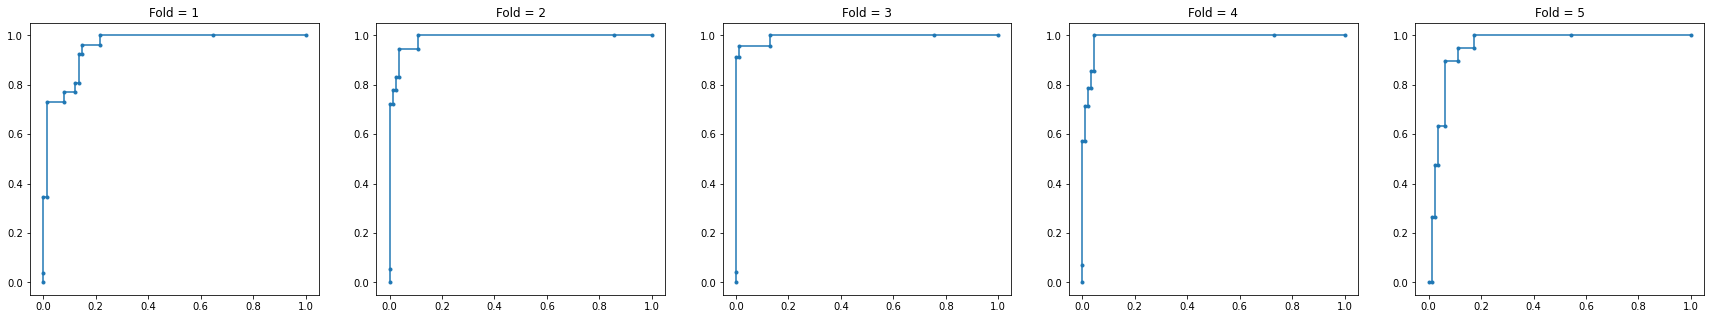

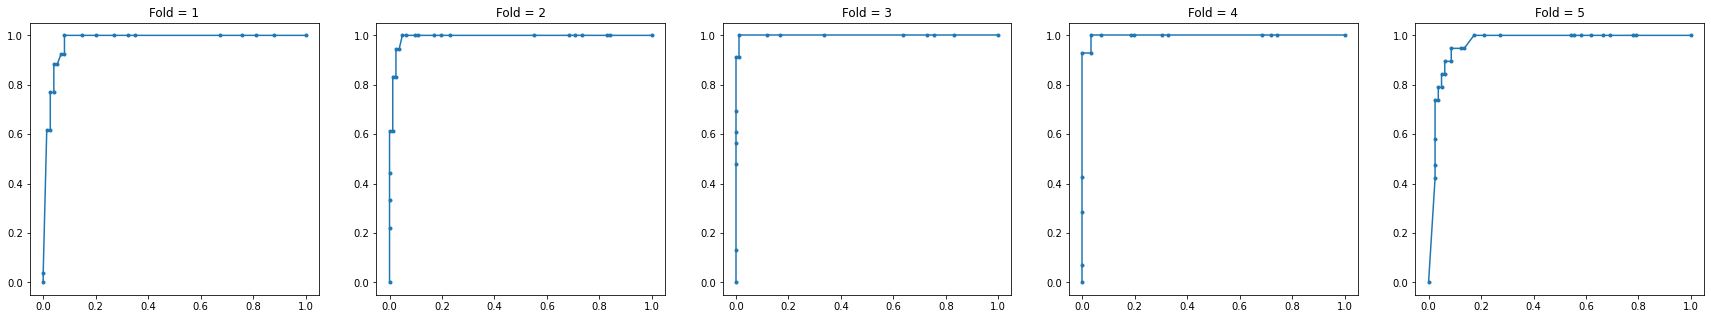

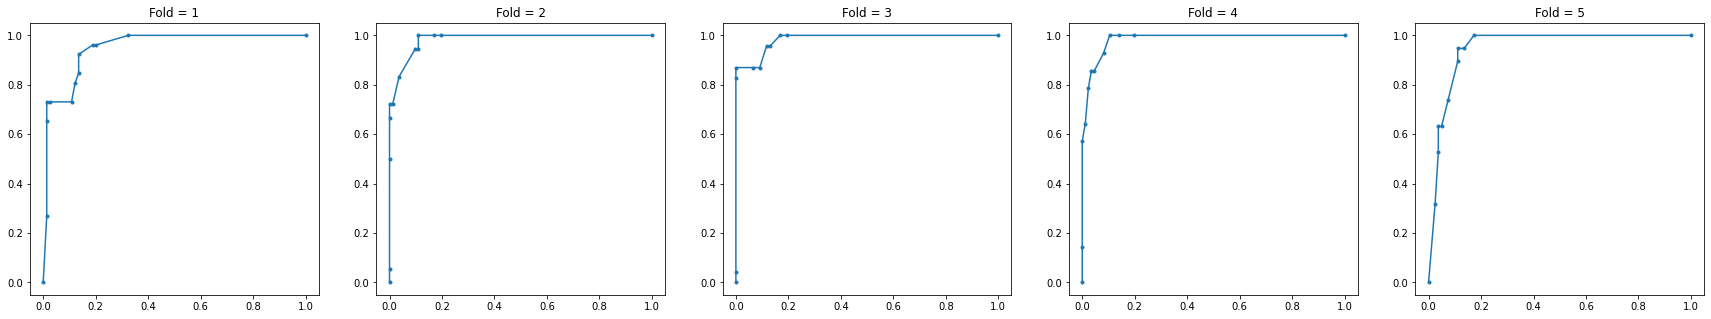

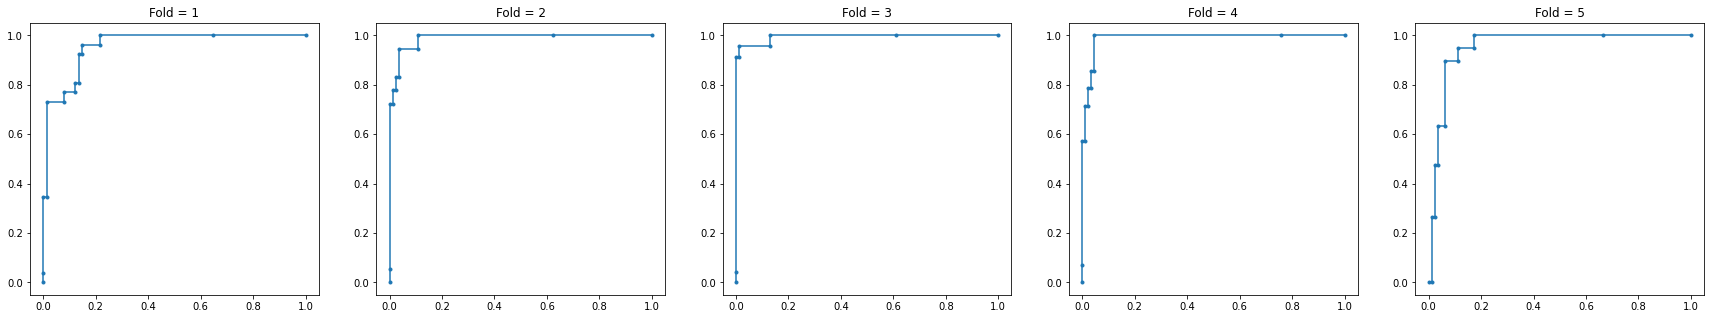

In [30]:
# SVM
algorithm_implementation(data_points_normalized_on_row, "SVM", True, best_svm_normalized_on_row_index)
# Random Forest
algorithm_implementation(data_points_normalized_on_row, "Random Forest", True, best_random_forest_normalized_on_row_index)
# KNN
algorithm_implementation(data_points_normalized_on_row, "KNN", True, best_knn_normalized_on_row_index)
# Best
if best_normalized_on_row_index == 0:
  algorithm_implementation(data_points_normalized_on_row, normalized_on_row_test_parameters_titles[best_normalized_on_row_index], True, best_svm_normalized_on_row_index)
elif best_not_normalized_index == 1:
  algorithm_implementation(data_points_normalized_on_row, normalized_on_row_test_parameters_titles[best_normalized_on_row_index], True, best_random_forest_normalized_on_row_index)
else:
  algorithm_implementation(data_points_normalized_on_row, normalized_on_row_test_parameters_titles[best_normalized_on_row_index], True, best_knn_normalized_on_row_index)

Processing Normalized Data Points on Column

In [31]:
data_points_normalized_on_column = normalization(data_points_not_normalized, "Column Normalization")

In [32]:
print("Normalized on Column Data Points :: SVM")
svm_normalized_on_column_test_parameters = algorithm_implementation(data_points_normalized_on_column, "SVM")

Normalized on Column Data Points :: SVM
linear  Kernel
Fold  1  =>  Accuracy =  0.94 	&  Precision =  0.955 	&  Recall =  0.808
Fold  2  =>  Accuracy =  0.94 	&  Precision =  0.929 	&  Recall =  0.722
Fold  3  =>  Accuracy =  0.99 	&  Precision =  1.0 	&  Recall =  0.957
Fold  4  =>  Accuracy =  0.97 	&  Precision =  1.0 	&  Recall =  0.786
Fold  5  =>  Accuracy =  0.92 	&  Precision =  0.824 	&  Recall =  0.737
poly  Kernel
Fold  1  =>  Accuracy =  0.95 	&  Precision =  0.957 	&  Recall =  0.846
Fold  2  =>  Accuracy =  0.95 	&  Precision =  0.933 	&  Recall =  0.778
Fold  3  =>  Accuracy =  1.0 	&  Precision =  1.0 	&  Recall =  1.0
Fold  4  =>  Accuracy =  0.98 	&  Precision =  1.0 	&  Recall =  0.857
Fold  5  =>  Accuracy =  0.92 	&  Precision =  0.824 	&  Recall =  0.737
rbf  Kernel
Fold  1  =>  Accuracy =  0.94 	&  Precision =  0.955 	&  Recall =  0.808
Fold  2  =>  Accuracy =  0.95 	&  Precision =  0.933 	&  Recall =  0.778
Fold  3  =>  Accuracy =  1.0 	&  Precision =  1.0 	&  R

In [33]:
print("Normalized on Column Data Points :: Random Forest")
random_forest_normalized_on_column_test_parameters = algorithm_implementation(data_points_normalized_on_column, "Random Forest")

Normalized on Column Data Points :: Random Forest
Number of Trees =  10
Fold  1  =>  Accuracy =  0.95 	&  Precision =  0.92 	&  Recall =  0.885
Fold  2  =>  Accuracy =  0.97 	&  Precision =  0.941 	&  Recall =  0.889
Fold  3  =>  Accuracy =  0.99 	&  Precision =  0.958 	&  Recall =  1.0
Fold  4  =>  Accuracy =  0.98 	&  Precision =  0.929 	&  Recall =  0.929
Fold  5  =>  Accuracy =  0.94 	&  Precision =  0.81 	&  Recall =  0.895
Number of Trees =  30
Fold  1  =>  Accuracy =  0.95 	&  Precision =  0.889 	&  Recall =  0.923
Fold  2  =>  Accuracy =  0.97 	&  Precision =  0.941 	&  Recall =  0.889
Fold  3  =>  Accuracy =  0.98 	&  Precision =  0.92 	&  Recall =  1.0
Fold  4  =>  Accuracy =  0.99 	&  Precision =  1.0 	&  Recall =  0.929
Fold  5  =>  Accuracy =  0.96 	&  Precision =  0.857 	&  Recall =  0.947
Number of Trees =  50
Fold  1  =>  Accuracy =  0.95 	&  Precision =  0.889 	&  Recall =  0.923
Fold  2  =>  Accuracy =  0.97 	&  Precision =  0.941 	&  Recall =  0.889
Fold  3  =>  Accu

In [34]:
print("Normalized on Column Data Points :: KNN")
knn_normalized_on_column_test_parameters = algorithm_implementation(data_points_normalized_on_column, "KNN")

Normalized on Column Data Points :: KNN
Number of Neighbors =  1
Fold  1  =>  Accuracy =  0.96 	&  Precision =  0.958 	&  Recall =  0.885
Fold  2  =>  Accuracy =  0.95 	&  Precision =  0.933 	&  Recall =  0.778
Fold  3  =>  Accuracy =  1.0 	&  Precision =  1.0 	&  Recall =  1.0
Fold  4  =>  Accuracy =  0.99 	&  Precision =  1.0 	&  Recall =  0.929
Fold  5  =>  Accuracy =  0.95 	&  Precision =  0.85 	&  Recall =  0.895
Number of Neighbors =  3
Fold  1  =>  Accuracy =  0.95 	&  Precision =  0.957 	&  Recall =  0.846
Fold  2  =>  Accuracy =  0.96 	&  Precision =  0.938 	&  Recall =  0.833
Fold  3  =>  Accuracy =  0.99 	&  Precision =  0.958 	&  Recall =  1.0
Fold  4  =>  Accuracy =  0.99 	&  Precision =  1.0 	&  Recall =  0.929
Fold  5  =>  Accuracy =  0.96 	&  Precision =  0.895 	&  Recall =  0.895
Number of Neighbors =  5
Fold  1  =>  Accuracy =  0.95 	&  Precision =  0.957 	&  Recall =  0.846
Fold  2  =>  Accuracy =  0.96 	&  Precision =  0.938 	&  Recall =  0.833
Fold  3  =>  Accuracy

In [35]:
kernels = ["linear", "poly", "rbf", "sigmoid"]
estimator_values = np.arange(10, 200, 20)
neighbor_values = np.arange(1, 50, 2)

In [36]:
best_svm_normalized_on_column_index = get_best(svm_normalized_on_column_test_parameters)
best_svm_normalized_on_column = svm_normalized_on_column_test_parameters[best_svm_normalized_on_column_index]
print("Best Normalized on Column Data Points :: SVM :: ", kernels[best_svm_normalized_on_column_index], " Kernel")
print("Accuracy = ", round(best_svm_normalized_on_column[0], 3), " & ", end = " ")
print("Precision = ", round(best_svm_normalized_on_column[1], 3), " & ", end = " ")
print("Recall = ", round(best_svm_normalized_on_column[2], 3), "\n")

best_random_forest_normalized_on_column_index = get_best(random_forest_normalized_on_column_test_parameters)
best_random_forest_normalized_on_column = random_forest_normalized_on_column_test_parameters[best_random_forest_normalized_on_column_index]
print("Best Normalized on Column Data Points :: Random Forest :: Estimator = ", estimator_values[best_random_forest_normalized_on_column_index])
print("Accuracy = ", round(best_random_forest_normalized_on_column[0], 3), " & ", end = " ")
print("Precision = ", round(best_random_forest_normalized_on_column[1], 3), " & ", end = " ")
print("Recall = ", round(best_random_forest_normalized_on_column[2], 3), "\n")

best_knn_normalized_on_column_index = get_best(knn_normalized_on_column_test_parameters)
best_knn_normalized_on_column = knn_normalized_on_column_test_parameters[best_knn_normalized_on_column_index]
print("Best Normalized on Column Data Points :: KNN :: Neighbors = ", neighbor_values[best_knn_normalized_on_column_index])
print("Accuracy = ", round(best_knn_normalized_on_column[0], 3), " & ", end = " ")
print("Precision = ", round(best_knn_normalized_on_column[1], 3), " & ", end = " ")
print("Recall = ", round(best_knn_normalized_on_column[2], 3), "\n")

normalized_on_column_test_parameters_titles = ["SVM", "Random Forest", "KNN"]
normalized_on_column_test_parameters = [best_svm_normalized_on_column, best_random_forest_normalized_on_column, best_knn_normalized_on_column]
best_normalized_on_column_index = get_best(normalized_on_column_test_parameters)
best_normalized_on_column = normalized_on_column_test_parameters[best_normalized_on_column_index]
print("Best Normalized on Column Data Points :: ", normalized_on_column_test_parameters_titles[best_normalized_on_column_index], " Algorithm")
print("Accuracy = ", round(best_normalized_on_column[0], 3), " & ", end = " ")
print("Precision = ", round(best_normalized_on_column[1], 3), " & ", end = " ")
print("Recall = ", round(best_normalized_on_column[2], 3), "\n")

Best Normalized on Column Data Points :: SVM ::  sigmoid  Kernel
Accuracy =  0.934  &  Precision =  0.975  &  Recall =  0.694 

Best Normalized on Column Data Points :: Random Forest :: Estimator =  90
Accuracy =  0.964  &  Precision =  0.888  &  Recall =  0.949 

Best Normalized on Column Data Points :: KNN :: Neighbors =  49
Accuracy =  0.938  &  Precision =  0.963  &  Recall =  0.718 

Best Normalized on Column Data Points ::  SVM  Algorithm
Accuracy =  0.934  &  Precision =  0.975  &  Recall =  0.694 



sigmoid  Kernel
Fold  1  =>  Accuracy =  0.89 	&  Precision =  0.941 	&  Recall =  0.615
Confusion Matrix: 
 [[73  1]
 [10 16]]
Fold  2  =>  Accuracy =  0.94 	&  Precision =  1.0 	&  Recall =  0.667
Confusion Matrix: 
 [[82  0]
 [ 6 12]]
Fold  3  =>  Accuracy =  0.94 	&  Precision =  1.0 	&  Recall =  0.739
Confusion Matrix: 
 [[77  0]
 [ 6 17]]
Fold  4  =>  Accuracy =  0.96 	&  Precision =  1.0 	&  Recall =  0.714
Confusion Matrix: 
 [[86  0]
 [ 4 10]]
Fold  5  =>  Accuracy =  0.94 	&  Precision =  0.933 	&  Recall =  0.737
Confusion Matrix: 
 [[80  1]
 [ 5 14]]


Number of Trees =  90
Fold  1  =>  Accuracy =  0.95 	&  Precision =  0.889 	&  Recall =  0.923
Confusion Matrix: 
 [[71  3]
 [ 2 24]]
Fold  2  =>  Accuracy =  0.97 	&  Precision =  0.941 	&  Recall =  0.889
Confusion Matrix: 
 [[81  1]
 [ 2 16]]
Fold  3  =>  Accuracy =  0.99 	&  Precision =  0.958 	&  Recall =  1.0
Confusion Matrix: 
 [[76  1]
 [ 0 23]]
Fold  4  =>  Accuracy =  0.98 	&  Precision =  0.929 	&  Recall =  0.929

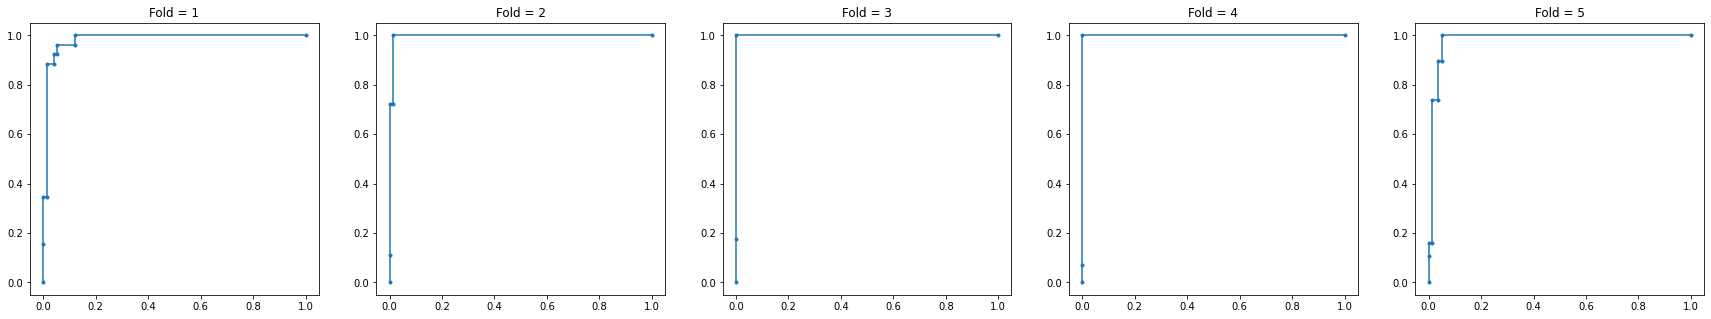

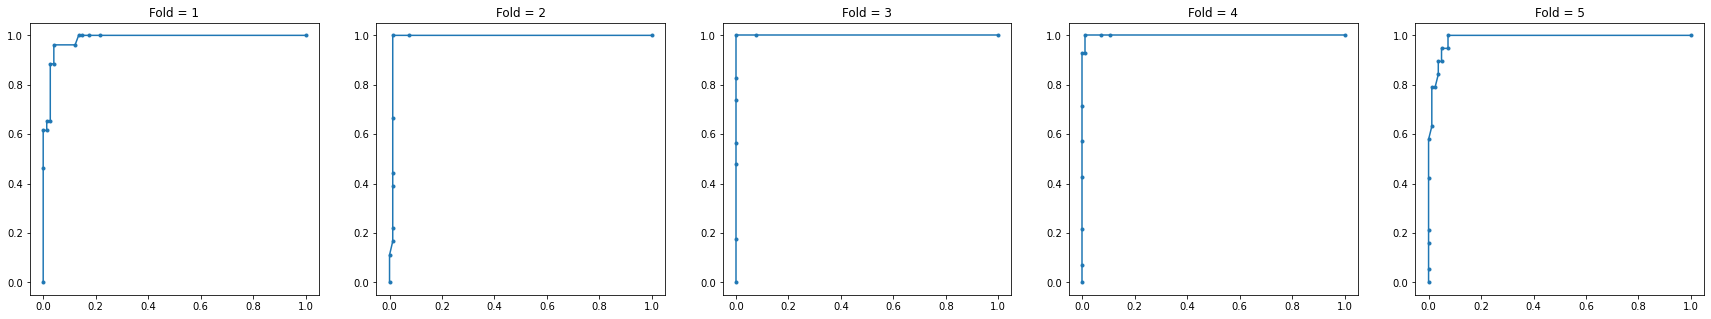

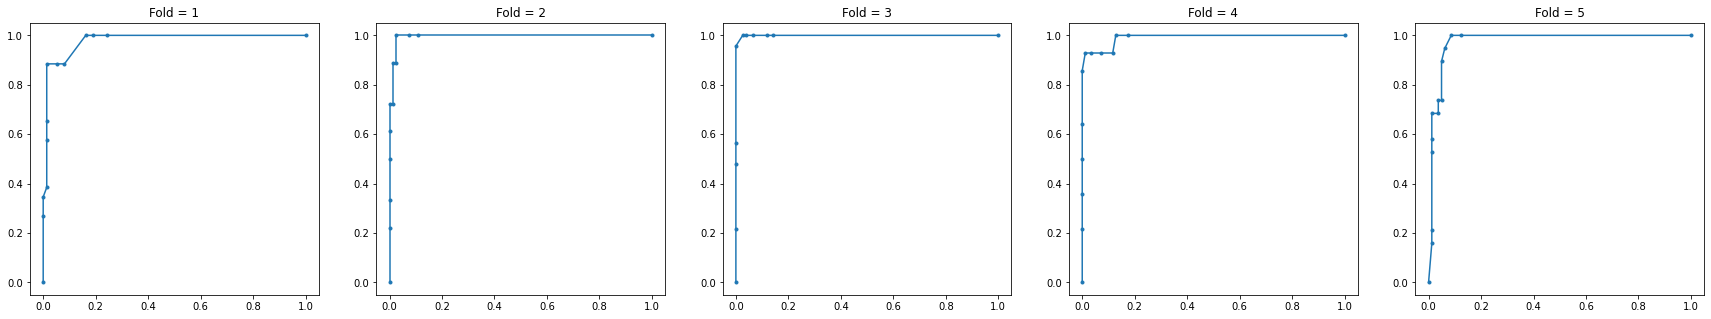

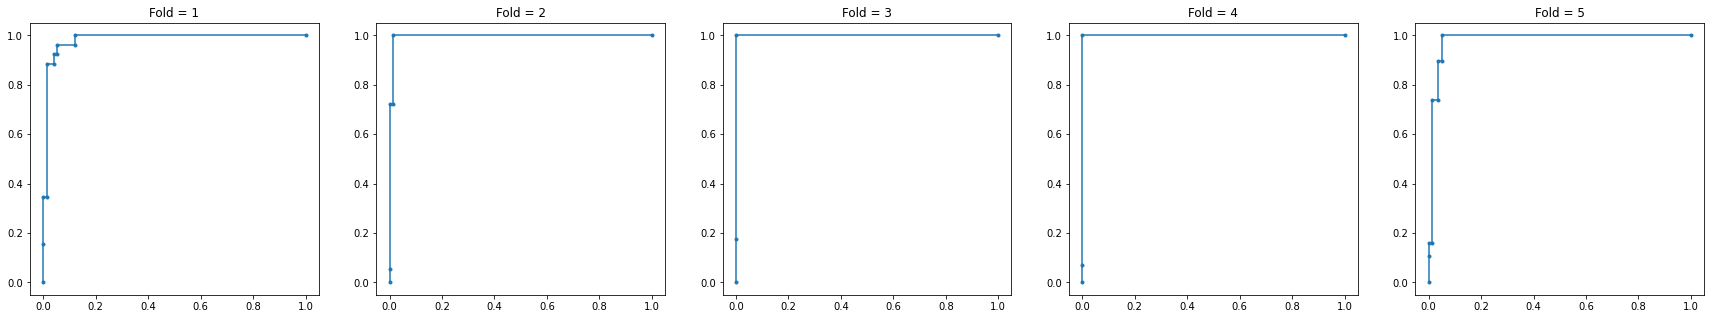

In [37]:
# SVM
algorithm_implementation(data_points_normalized_on_column, "SVM", True, best_svm_normalized_on_column_index)
# Random Forest
algorithm_implementation(data_points_normalized_on_column, "Random Forest", True, best_random_forest_normalized_on_column_index)
# KNN
algorithm_implementation(data_points_normalized_on_column, "KNN", True, best_knn_normalized_on_column_index)
# Best
if best_normalized_on_column_index == 0:
  algorithm_implementation(data_points_normalized_on_column, normalized_on_column_test_parameters_titles[best_normalized_on_column_index], True, best_svm_normalized_on_column_index)
elif best_normalized_on_column_index == 1:
  algorithm_implementation(data_points_normalized_on_column, normalized_on_column_test_parameters_titles[best_normalized_on_column_index], True, best_random_forest_normalized_on_column_index)
else:
  algorithm_implementation(data_points_normalized_on_column, normalized_on_column_test_parameters_titles[best_normalized_on_column_index], True, best_knn_normalized_on_column_index)